In [91]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="1"
import pandas as pd
# import seaborn as sns
# sns.set_theme()
# import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.metrics import roc_curve, RocCurveDisplay
from sklearn.model_selection import train_test_split
import numpy as np
import torch
from torch import nn
import torch.optim.adam
from torch.utils.data import TensorDataset, DataLoader
print(torch.__version__)

2.5.1+cu124


In [12]:
if torch.cuda.is_available():
    device = "cuda:0"
else: device = "cpu"
print(f"current device {device}")

current device cuda:0


In [69]:
embeddings = Path("iadh_out/ath_bol_aar/emebddings_blocks_24_mlp_l3_sttras_30_A0.tsv")
df = pd.read_csv(embeddings, sep="\t", header=0, index_col=0)
df.em_x = df.em_x.apply(eval)
df.em_y = df.em_y.apply(eval)

In [193]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(3840, 512),
            nn.ReLU(),
            nn.BatchNorm1d(512),
            nn.Dropout1d(0.3),

            nn.Linear(512, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Dropout1d(0.3),

            nn.Linear(128, 32),
            nn.ReLU(),
            nn.BatchNorm1d(32),
            nn.Linear(32, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

In [196]:
model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=3840, out_features=512, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout1d(p=0.3, inplace=False)
    (4): Linear(in_features=512, out_features=128, bias=True)
    (5): ReLU()
    (6): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout1d(p=0.3, inplace=False)
    (8): Linear(in_features=128, out_features=32, bias=True)
    (9): ReLU()
    (10): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): Linear(in_features=32, out_features=1, bias=True)
    (12): Sigmoid()
  )
)


In [136]:
samples = df.em_x + df.em_y
y = df.similar.astype(int).values
x = np.array(samples.values.tolist())

x, x_val, y, y_val = train_test_split(x, y, test_size=0.30, random_state=42)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=42)

train_dataloader = DataLoader(
    TensorDataset(
        torch.tensor(x_train, dtype=torch.float32), 
        torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
        ), 
    batch_size=16
    )
test_dataloader = DataLoader(
    TensorDataset(
        torch.tensor(x_test, dtype=torch.float32), 
        torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)
        ), 
    batch_size=16
    )


In [179]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        # print(batch)
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred.round(), y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 10 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


In [182]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()

            # pred is now a float
            # should be converted to int
            # then update all the shit

            correct += (pred.round() == y).type(torch.float).sum().item()
            # print((pred == y).shape)
            # print(pred.shape)
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [203]:
model = ""
model = NeuralNetwork().to(device)
epochs = 10
loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), )
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 37.500000  [   16/ 1241]
loss: 37.500000  [  176/ 1241]
loss: 43.750000  [  336/ 1241]
loss: 43.750000  [  496/ 1241]
loss: 50.000000  [  656/ 1241]
loss: 68.750000  [  816/ 1241]
loss: 56.250000  [  976/ 1241]
loss: 43.750000  [ 1136/ 1241]
Test Error: 
 Accuracy: 49.2%, Avg loss: 0.696729 

Epoch 2
-------------------------------
loss: 31.250000  [   16/ 1241]
loss: 37.500000  [  176/ 1241]
loss: 43.750000  [  336/ 1241]
loss: 37.500000  [  496/ 1241]
loss: 50.000000  [  656/ 1241]
loss: 81.250000  [  816/ 1241]
loss: 56.250000  [  976/ 1241]
loss: 43.750000  [ 1136/ 1241]
Test Error: 
 Accuracy: 49.2%, Avg loss: 0.691493 

Epoch 3
-------------------------------
loss: 37.500000  [   16/ 1241]
loss: 37.500000  [  176/ 1241]
loss: 43.750000  [  336/ 1241]
loss: 37.500000  [  496/ 1241]
loss: 43.750000  [  656/ 1241]
loss: 68.750000  [  816/ 1241]
loss: 56.250000  [  976/ 1241]
loss: 43.750000  [ 1136/ 1241]
Test Error: 
 Accuracy: 49.2%, A

In [3]:
def calc_cosine(r: pd.Series):
    em_x = r["em_x"]
    # print(em_x)
    em_y = r["em_y"]
    # m = max(len(em_x),len(em_y) )
    # em_x = np.concat((em_x, np.zeros(m-len(em_x))))
    # em_y = np.concat((em_y, np.zeros(m-len(em_y))))
    return np.dot(em_x, em_y)/ (np.linalg.norm(em_x) * np.linalg.norm(em_y))
df["cosine_sim"] = df.apply(calc_cosine, axis=1)

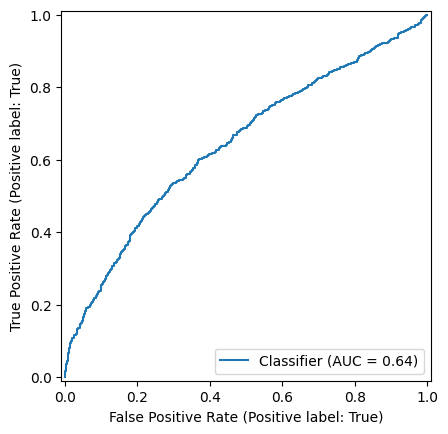

In [4]:
RocCurveDisplay.from_predictions(df["similar"].tolist(), df["cosine_sim"].tolist(), pos_label=True)